## Parte 0 - Importando as Bibliotecas Neurais

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np

In [4]:
# Criando um dicinário com os metaparâmetros
args = {
    'batch_size'  : 200, #200
    'num_workers' : 4,
    'num_classes' : 10,
    'lr'          : 1e-3, #5e-5
    'weight_decay': 3e-6,
    'num_epochs'  : 200,
    'momentum'    : 0.9,
    'size_shape'  : 138, #128, #950 
    'size_shape2' : 46,  #36,  #600  # 0.0015
    'size_shape3' : 2    #80
}


In [5]:
# Salvando o Dicinário com os metaparâmetros
#np.save('../datasets/mlp_param.npy', args)
arq = open('../datasets/mlp_param.txt', 'w')
arq.write(str(args))
arq.close()

In [6]:
# Testando a disponibilidade da GPU
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cpu


### Parte 1 - Aquisição dos Dados

In [7]:
#Bibliotecas
import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(15,7))

In [8]:
# ** Carregando a base de dados **
# O Arquivo "dataset_cafe_estatistica.csv" contém dados tratados de 
# todos os arquivos ".alog" que representam os "batches" de torra gerados 
# pelo "Artisan". Este tratamento básico consiste na aquisição e verificação de 
# validade qualitativa, reduzindo valores incorretos e absurdos, além da anállise
# de valores centrais e frequência.
# O tratamento realizado anteriormente mencionado foi feito pelo 'script' 
# 'DataSci_inovagrao.ipynb'

# Carregando o arquivo "dataset_cafe.csv"
dataset_util = pd.read_csv('../datasets/dataset_cafe_estatistica.csv',index_col=0)
dataset_util_original = dataset_util.copy()
display(dataset_util_original.head())
print(dataset_util_original.shape)

,batch,grao,temp_amb,umid_amb,peso,timex,temp2,charge_bt_modificado,massa_grao,categoria_massa
0,0,cafe_saulo_especial,30.7,0.61,"[2000.0, 1715.0, 'g']",58.645580,215.230873,215.230873,2000,Acima de 2000
1,0,cafe_saulo_especial,30.7,0.61,"[2000.0, 1715.0, 'g']",60.646011,213.678067,215.230873,2000,Acima de 2000
2,0,cafe_saulo_especial,30.7,0.61,"[2000.0, 1715.0, 'g']",62.646332,199.982852,215.230873,2000,Acima de 2000
3,0,cafe_saulo_especial,30.7,0.61,"[2000.0, 1715.0, 'g']",64.650602,185.970144,215.230873,2000,Acima de 2000
4,0,cafe_saulo_especial,30.7,0.61,"[2000.0, 1715.0, 'g']",66.646807,172.630521,215.230873,2000,Acima de 2000


(12680, 10)


### Parte 2 - Estatísticas Descritivas dos dados

In [9]:
dataset_util.describe().round(2)

,batch,temp_amb,umid_amb,timex,temp2,charge_bt_modificado,massa_grao
count,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00,12680.00
mean,22.76,29.57,0.56,309.27,147.81,209.86,1787.05
std,13.44,1.68,0.05,164.22,36.33,16.31,458.64
min,0.00,26.00,0.49,0.64,68.15,119.39,450.00
25%,11.00,29.20,0.52,171.07,117.22,210.86,2000.00
50%,23.00,30.00,0.56,304.24,151.95,214.57,2000.00
75%,33.00,30.72,0.60,439.09,179.28,216.88,2000.00
max,47.00,31.80,0.64,723.03,224.50,224.50,2300.00


### Parte 3 -  Coeficiênte de Correlação dos Dados

In [10]:
dataset_util.corr().round(4)

,batch,temp_amb,umid_amb,timex,temp2,charge_bt_modificado,massa_grao
batch,1.0000,-0.6276,-0.5234,-0.0580,-0.0030,-0.1185,-0.3341
temp_amb,-0.6276,1.0000,0.3077,0.1195,0.0683,0.0062,0.0621
umid_amb,-0.5234,0.3077,1.0000,0.0849,0.0182,0.1494,0.1095
timex,-0.0580,0.1195,0.0849,1.0000,0.8443,0.0582,0.0844
temp2,-0.0030,0.0683,0.0182,0.8443,1.0000,-0.0237,-0.0498
charge_bt_modificado,-0.1185,0.0062,0.1494,0.0582,-0.0237,1.0000,0.4136
massa_grao,-0.3341,0.0621,0.1095,0.0844,-0.0498,0.4136,1.0000


### Zerando os valores de tempo mínimos (Deslocamento do gráfico à origem do tempo)

In [11]:
# Deslocamento do tempo à sua origem
cat_tipo_graos = dataset_util['grao'].unique()
for grao in cat_tipo_graos:
    batch = dataset_util[dataset_util['grao'] == grao]['batch'].unique()
    print(grao)
    print(batch)
    for lote in batch:
        filtro1 = list(dataset_util['grao'] == grao)
        filtro2 = list(dataset_util['batch'] == lote)
        filtro  = filtro1 and filtro2
        temp = dataset_util[filtro1 and filtro2]['timex']
        temp_min = temp.min()
        temp = temp - temp_min
        #print(temp.index)
        dataset_util.loc[temp.index, 'timex'] = temp
        #print(len(filtro1), len(filtro2))
        
dataset_util

cafe_saulo_especial
[ 0  1  2  3  4  5  6 12 13 14 15]
cafe_saulo_gourmet
[ 7  8  9 10 11 16 17 18 19 20 21]
vo_mira_arabica
[22 23 24 25 26 27]
vo_mira_conilon
[28 29 30 31 32 33 34]
cafe_do_mario
[35 36 37 38 39 40 41 42 43 44 45 46 47]


,batch,grao,temp_amb,umid_amb,peso,timex,temp2,charge_bt_modificado,massa_grao,categoria_massa
0,0,cafe_saulo_especial,30.7,0.61,"[2000.0, 1715.0, 'g']",0.000000,215.230873,215.230873,2000,Acima de 2000
1,0,cafe_saulo_especial,30.7,0.61,"[2000.0, 1715.0, 'g']",2.000432,213.678067,215.230873,2000,Acima de 2000
2,0,cafe_saulo_especial,30.7,0.61,"[2000.0, 1715.0, 'g']",4.000752,199.982852,215.230873,2000,Acima de 2000
3,0,cafe_saulo_especial,30.7,0.61,"[2000.0, 1715.0, 'g']",6.005022,185.970144,215.230873,2000,Acima de 2000
4,0,cafe_saulo_especial,30.7,0.61,"[2000.0, 1715.0, 'g']",8.001227,172.630521,215.230873,2000,Acima de 2000
...,...,...,...,...,...,...,...,...,...,...
12675,47,cafe_do_mario,28.0,0.58,"[600.0, 0.0, 'g']",510.000187,196.340843,186.634894,600,Abaixo de 2000
12676,47,cafe_do_mario,28.0,0.58,"[600.0, 0.0, 'g']",512.000869,196.536785,186.634894,600,Abaixo de 2000
12677,47,cafe_do_mario,28.0,0.58,"[600.0, 0.0, 'g']",514.000553,196.763094,186.634894,600,Abaixo de 2000
12678,47,cafe_do_mario,28.0,0.58,"[600.0, 0.0, 'g']",516.000238,197.011429,186.634894,600,Abaixo de 2000


## Parte 4 - Preparando a Base de Dados

In [12]:
# Tratando os dados categóricos 'grao' (Categoria de Grãos)
cat_tipo_graos = dataset_util['grao']
cat_tipo_graos = cat_tipo_graos.unique()

for col in cat_tipo_graos:
  dataset_util.insert(1,col,0,allow_duplicates=False) # Inserindo a coluna da categoria
  loc = dataset_util[dataset_util['grao'] == col].index
  dataset_util.loc[loc, col] = 1 # Setando valor na categoria

del dataset_util['grao']

#Elminando a coluna 'peso'
del dataset_util['peso']
#Eliminando a coluna 'massa_grao'
del dataset_util['massa_grao']
#Eliminando a coluna 'batch'
del dataset_util['batch']

# Tratando os dados categóricos 'categoria_massa' (Acima de 2Kg ou Abaixo de 2Kg)
cat_massa_graos = dataset_util['categoria_massa']
cat_massa_graos = cat_massa_graos.unique()

for col in cat_massa_graos:
  dataset_util.insert(dataset_util.shape[1],col,0,allow_duplicates=False) # Inserindo a coluna da categoria
  loc = dataset_util[dataset_util['categoria_massa'] == col].index
  dataset_util.loc[loc, col] = 1 # Setando valor na categoria

del dataset_util['categoria_massa']

dataset_util.to_csv('../datasets/dataset_util.csv')

dataset_util

,cafe_do_mario,vo_mira_conilon,vo_mira_arabica,cafe_saulo_gourmet,cafe_saulo_especial,temp_amb,umid_amb,timex,temp2,charge_bt_modificado,Acima de 2000,Abaixo de 2000
0,0,0,0,0,1,30.7,0.61,0.000000,215.230873,215.230873,1,0
1,0,0,0,0,1,30.7,0.61,2.000432,213.678067,215.230873,1,0
2,0,0,0,0,1,30.7,0.61,4.000752,199.982852,215.230873,1,0
3,0,0,0,0,1,30.7,0.61,6.005022,185.970144,215.230873,1,0
4,0,0,0,0,1,30.7,0.61,8.001227,172.630521,215.230873,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12675,1,0,0,0,0,28.0,0.58,510.000187,196.340843,186.634894,0,1
12676,1,0,0,0,0,28.0,0.58,512.000869,196.536785,186.634894,0,1
12677,1,0,0,0,0,28.0,0.58,514.000553,196.763094,186.634894,0,1
12678,1,0,0,0,0,28.0,0.58,516.000238,197.011429,186.634894,0,1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


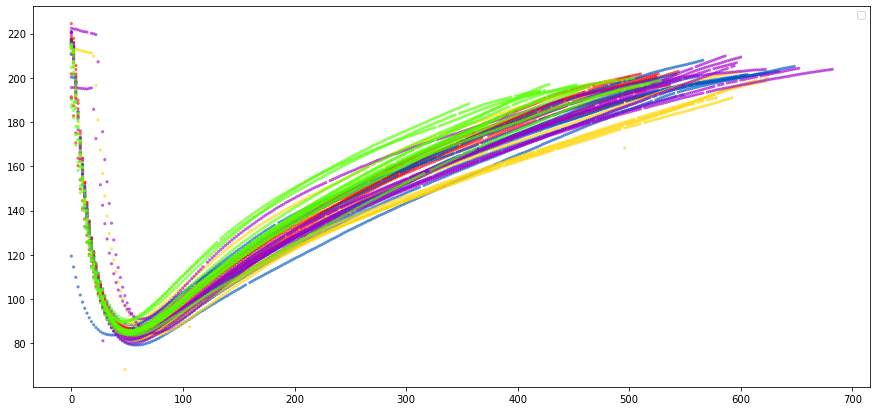

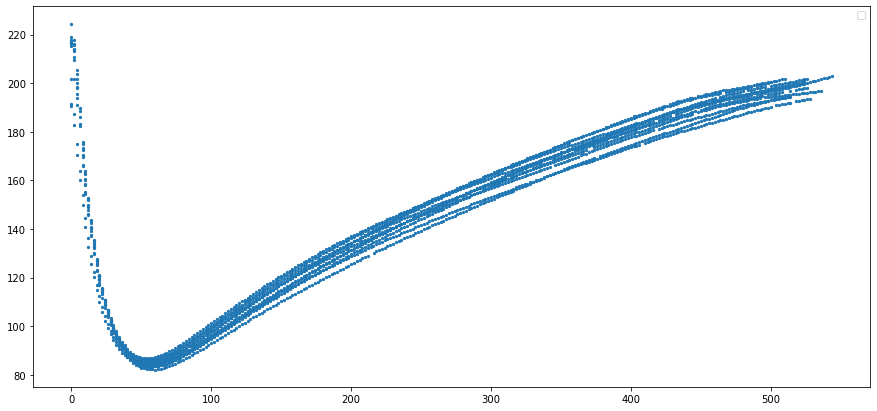

In [13]:
#graos='b' #Tirar isso depois
cor = 0
graos = dataset_util_original['grao'].copy()
for col in cat_tipo_graos:
  for lin in range(graos.shape[0]):
    if graos[lin] == col:
      graos[lin] = cor
  cor += 1

#print(graos)
plt.figure()
plt.scatter(dataset_util['timex'], dataset_util['temp2'],c=graos, s=5, alpha=0.5, cmap='prism')
plt.legend()

plt.figure()
plt.scatter(dataset_util[dataset_util['cafe_saulo_especial']==1]['timex'], 
            dataset_util[dataset_util['cafe_saulo_especial']==1]['temp2'], s=5)
plt.legend()

## Parte 5 - Normalização da Entrada de dados

In [14]:
#from sklearn.preprocessing import MinMaxScaler
def minmax_norm(df_input):
  return(df_input - df_input.min()) / (df_input.max() - df_input.min())

dataset_util_norm = minmax_norm(dataset_util)

dataset_util_norm.to_csv('../datasets/dataset_util_norm.csv')

#plt.figure()
#plt.scatter(dataset_util_norm['timex'], dataset_util_norm['temp2'], s=5)

In [15]:
#display(dataset_util_norm.head())
print('Tamanho da População: %d' % dataset_util_norm.shape[0])

Tamanho da População: 12680


In [16]:
# Para Ampliar a influência dos valores iniciais, 
# ampliarei a amostragem destes pontos repeteindo 
# na base
selecao = dataset_util['timex'] < 200
for i in range(2):
    dataset_util_norm = pd.concat([dataset_util_norm, dataset_util_norm[selecao]], ignore_index=False)
    dataset_util = pd.concat([dataset_util, dataset_util[selecao]], ignore_index=False)
    dataset_util_original = pd.concat([dataset_util_original, dataset_util_original[selecao]], ignore_index=False)
print(dataset_util.shape)
print(dataset_util_norm.shape)

(26927, 12)
(26927, 12)


/tmp/ipykernel_11438/762270270.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset_util_norm = pd.concat([dataset_util_norm, dataset_util_norm[selecao]], ignore_index=False)
/tmp/ipykernel_11438/762270270.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset_util = pd.concat([dataset_util, dataset_util[selecao]], ignore_index=False)
/tmp/ipykernel_11438/762270270.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset_util_original = pd.concat([dataset_util_original, dataset_util_original[selecao]], ignore_index=False)


## Parte 6 - Selecionando Amostras de Treino e Teste

In [17]:
# Selecionando uma amostra para treino e teste
#torch.manual_seed(1) # Mantendo a mesma aleatoriedade
indices    = torch.randperm(dataset_util_norm.shape[0]).tolist()
train_size = int(0.75 * dataset_util_norm.shape[0])
df_train   = dataset_util_norm.iloc[indices[:train_size]]
df_test    = dataset_util_norm.iloc[indices[train_size:]]
print('Tamanho da Amostra de Treino: %d' % df_train.shape[0])
print('Tamanho da Amostra de Teste: %d' % df_test.shape[0])
display(df_train.head())

Tamanho da Amostra de Treino: 20195
Tamanho da Amostra de Teste: 6732


,cafe_do_mario,vo_mira_conilon,vo_mira_arabica,cafe_saulo_gourmet,cafe_saulo_especial,temp_amb,umid_amb,timex,temp2,charge_bt_modificado,Acima de 2000,Abaixo de 2000
6882,0.0,0.0,1.0,0.0,0.0,0.741379,0.533333,0.000000,0.926938,0.891321,0.0,1.0
4839,0.0,0.0,0.0,1.0,0.0,0.586207,0.466667,0.686216,0.753384,0.932147,1.0,0.0
10185,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.422287,0.593568,0.899365,1.0,0.0
284,0.0,0.0,0.0,0.0,1.0,0.775862,0.866667,0.085045,0.096335,0.922409,1.0,0.0
3297,0.0,0.0,0.0,0.0,1.0,0.879310,0.200000,0.005866,0.830506,0.932802,1.0,0.0


In [18]:
# Criando o nosso DataSet
class Dataset_amostras(Dataset):
    def __init__(self, df):
        self.dados = df.to_numpy()
        
    def __getitem__(self, idx):
        sample = self.dados[idx][[0,1,2,3,4,5,6,7,9,10,11]]
        label  = self.dados[idx][8:9]
        
        # Converter para Tensor
        sample = torch.from_numpy(sample.astype(np.float32))
        label  = torch.from_numpy(label.astype(np.float32))
        return sample, label
    
    def __len__(self):
        return len(self.dados)

train_set = Dataset_amostras(df_train)
test_set  = Dataset_amostras(df_test)

dado, rotulo = train_set[0]
print(rotulo)
print(dado)

tensor([0.9269])
tensor([0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.7414, 0.5333, 0.0000, 0.8913,
        0.0000, 1.0000])


In [19]:
# Utilizando o Dataloader para criar os batches de treinamento
train_loader = DataLoader(train_set,
                          batch_size = args['batch_size'],
                          shuffle = True,
                          num_workers = args['num_workers'])
test_loader = DataLoader( test_set,
                          batch_size = args['batch_size'],
                          shuffle = True,
                          num_workers = args['num_workers'])

for batch in train_loader:
    dado, rotulo = batch
    #print(dado.size(), rotulo.size())
    print(dado.shape, rotulo.shape)
    break

torch.Size([200, 11]) torch.Size([200, 1])


## Criando a REDE MLP


In [20]:
# Implementando a MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, out_size):
        super(MLP, self).__init__()
        
        self.features = nn.Sequential(
                                nn.Linear(input_size, hidden_size),
                                nn.ReLU(),
                                nn.Linear(hidden_size, hidden_size2),
                                nn.ReLU(),
#                                nn.Linear(hidden_size2, hidden_size3),
#                                nn.ReLU(),
                        )
        self.out     = nn.Linear(hidden_size2, out_size)
        #self.softmax = nn.Softmax() 
    def forward(self, X):
        #X = X.view(X.size(0), -1) # Linearizando a imagem
        
        feature = self.features(X)
        output  = self.out(feature)
        return output

input_size  = dado.shape[1]
hidden_size = args['size_shape']
hidden_size2 = args['size_shape2']
hidden_size3 = args['size_shape3']
out_size    = 1 # nº de variáveis preditas

net = MLP(input_size, hidden_size, hidden_size2, out_size).to(args['device']) # Se tiver GPU

In [21]:
# Definindo loss e otimizador
#criterion = nn.L1Loss().to(args['device'])
criterion = nn.MSELoss().to(args['device'])
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
#optimizer = optim.SGD(net.parameters(), lr=args['lr'], momentum=args['momentum'], weight_decay=args['weight_decay'])

In [22]:
# Treino
def train(train_loader, net, epoch, verbose=True):
    
    net.train()
    
    epoch_loss = []
    for batch in train_loader:
        dado, rotulo = batch
        
        #Cast na GPU
        dado   = dado.to(args['device'])
        rotulo = rotulo.to(args['device'])
        
        #Forward
        pred       = net(dado)
        loss       = criterion(pred, rotulo)
        epoch_loss.append(loss.cpu().data)
        
        #Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    epoch_loss = np.asarray(epoch_loss)
    if verbose:
       print('Época: %d, Loss: %.4f, +/-%.4f' % (epoch, epoch_loss.mean(), epoch_loss.std()))
    return(epoch_loss.mean())

In [23]:
# Teste - Validação
def test(test_loader, net, epoch, verbose=True):
    
    net.eval()
    
    with torch.no_grad():
        epoch_loss = []
        for batch in test_loader:
            dado, rotulo = batch

            #Cast na GPU
            dado   = dado.to(args['device'])
            rotulo = rotulo.to(args['device'])

            #Forward
            pred       = net(dado)
            loss       = criterion(pred, rotulo)
            epoch_loss.append(loss.cpu().data)

        epoch_loss = np.asarray(epoch_loss)
        if verbose:
           print('Época: %d, Loss: %.4f, +/-%.4f' % (epoch, epoch_loss.mean(), epoch_loss.std()))
        return(epoch_loss.mean())

## Testando um Lote de Torra como comparação

In [24]:
teste_idx1 = (dataset_util_original['grao'] == 'cafe_saulo_especial') 
teste_idx2 = (dataset_util_original['batch'] == 0)
teste_idx = (teste_idx1.to_list() and teste_idx2.to_list())
dataset_util_norm[teste_idx].shape[0]

558

Época: 0, Treino: 0.0397, Teste: 0.0221


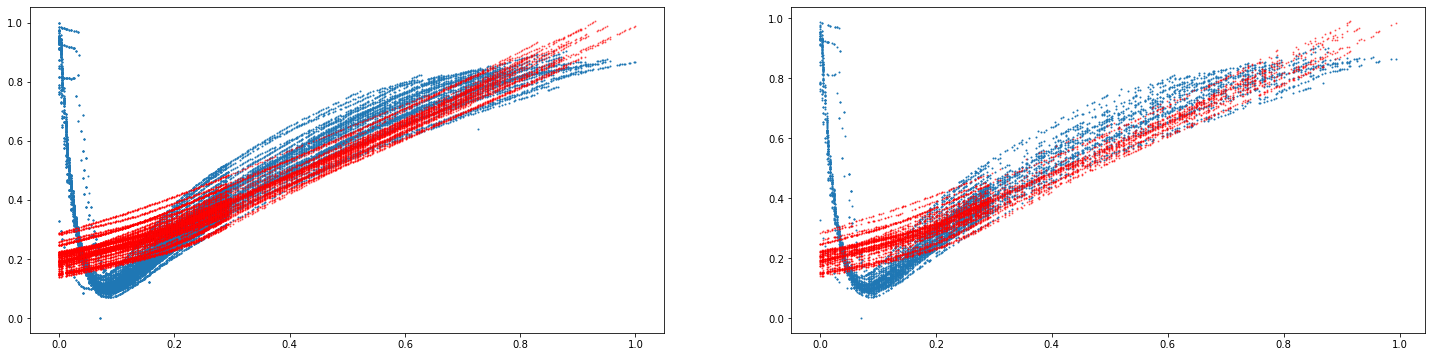

Época: 20, Treino: 0.0007, Teste: 0.0007


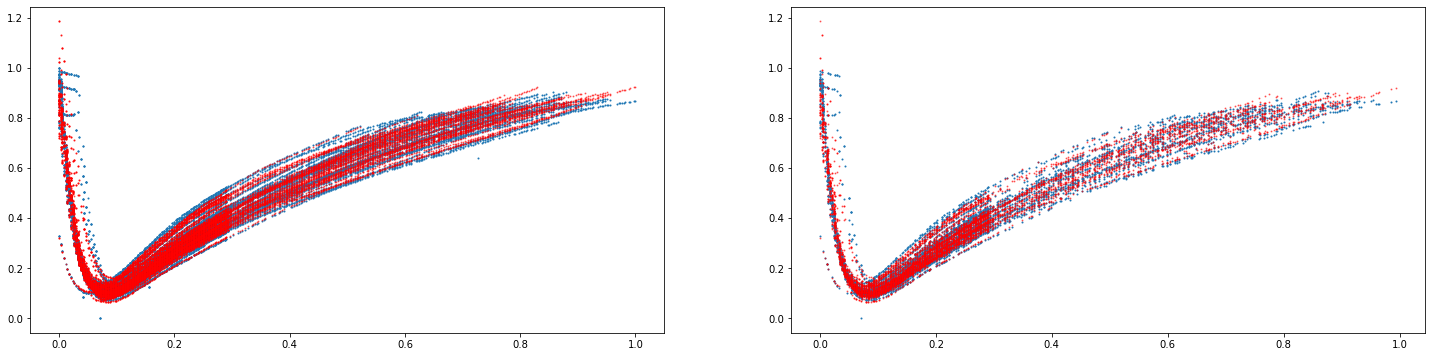

Época: 40, Treino: 0.0004, Teste: 0.0005


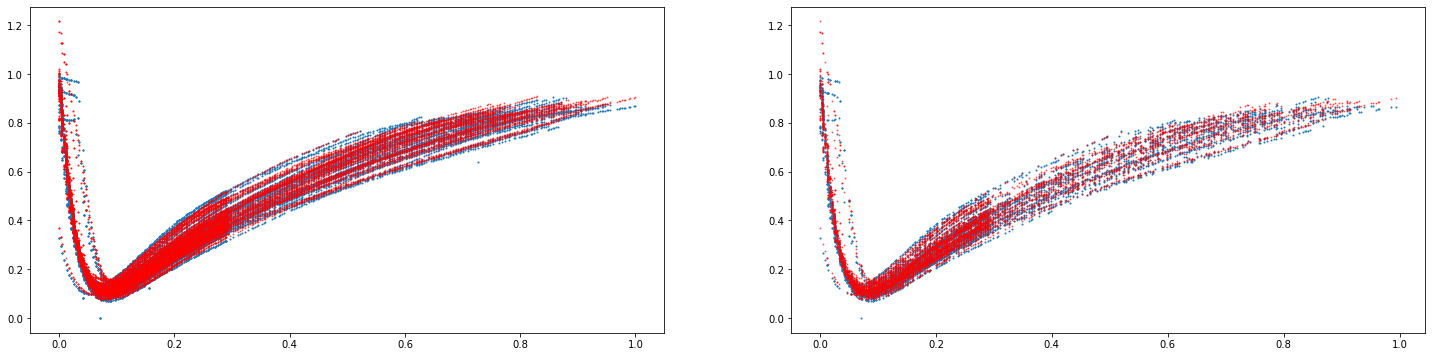

Época: 60, Treino: 0.0003, Teste: 0.0004


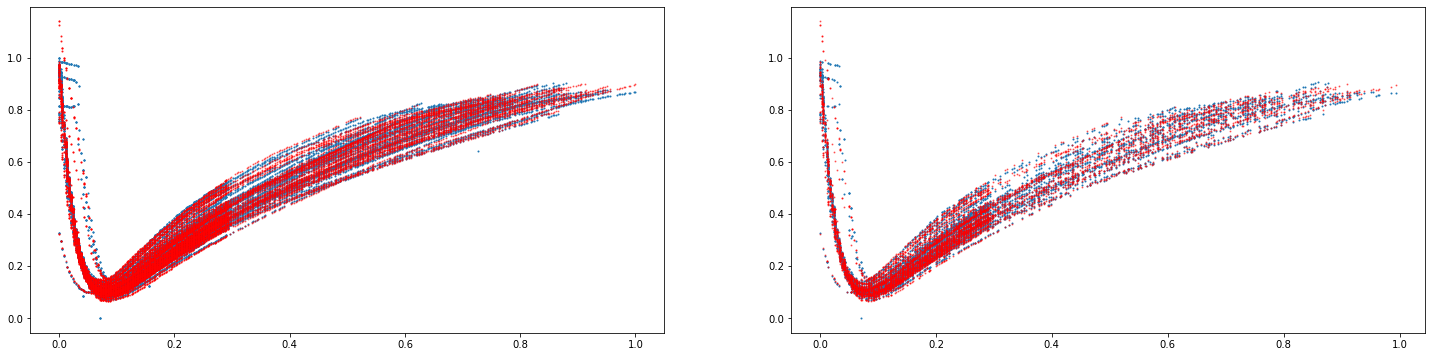

Época: 80, Treino: 0.0003, Teste: 0.0003


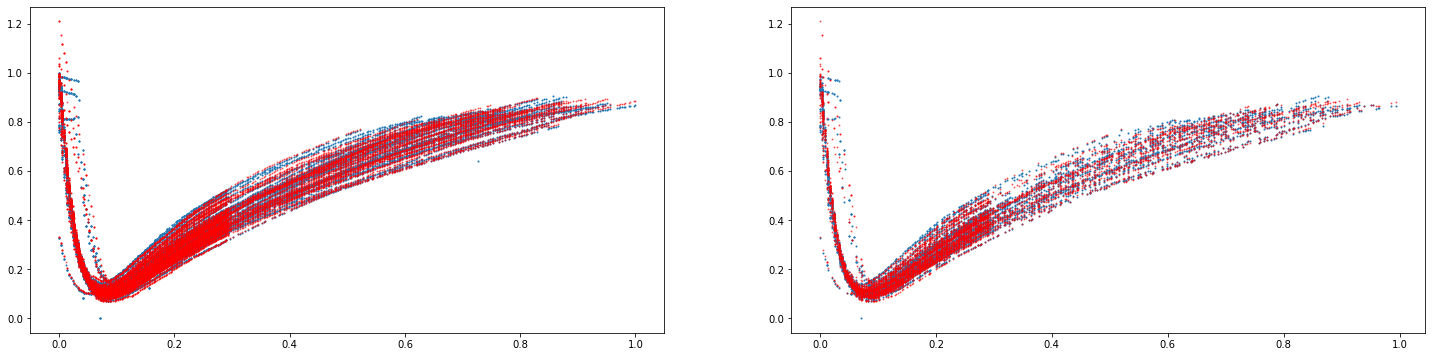

Época: 100, Treino: 0.0002, Teste: 0.0003


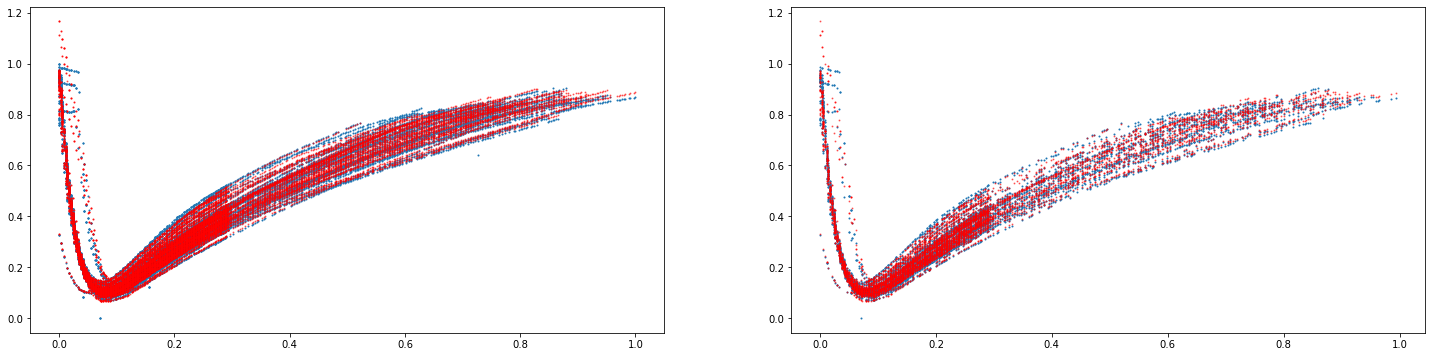

Época: 120, Treino: 0.0003, Teste: 0.0003


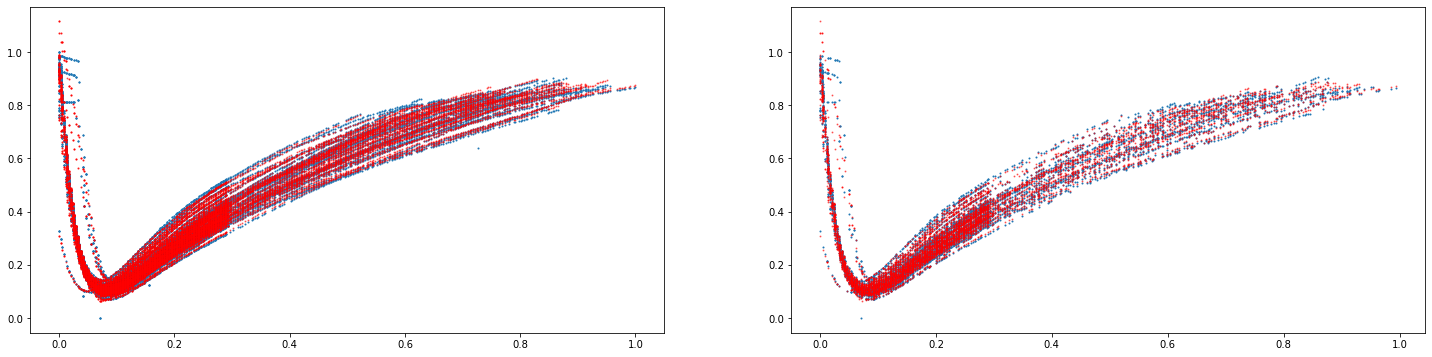

Época: 140, Treino: 0.0002, Teste: 0.0002


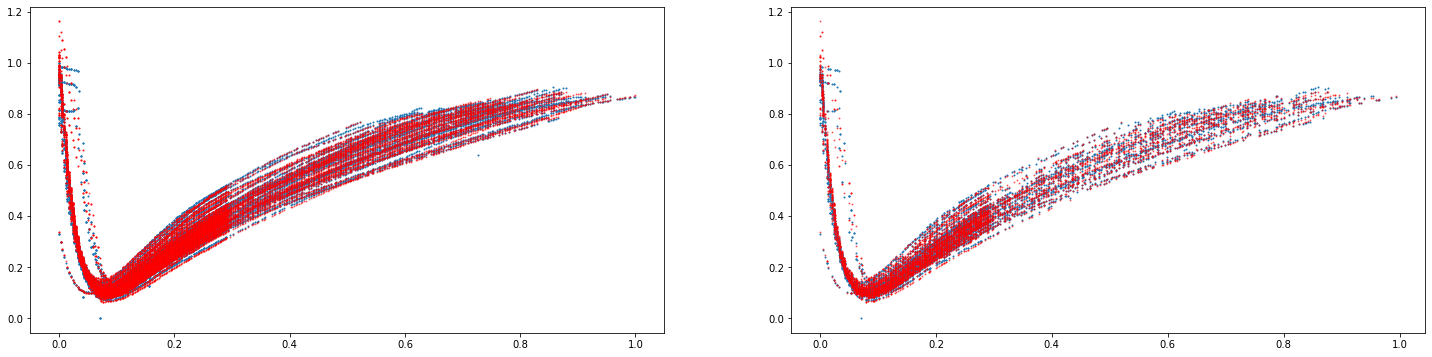

Época: 160, Treino: 0.0002, Teste: 0.0002


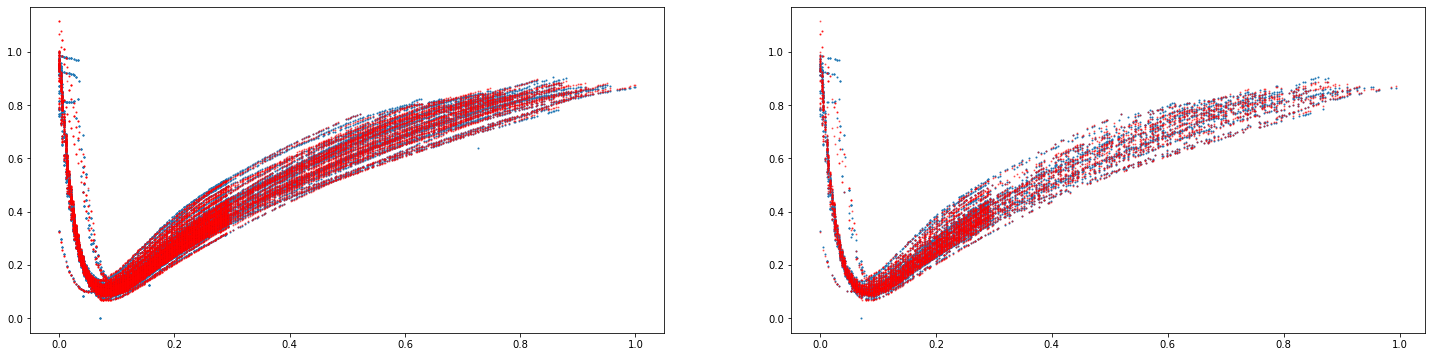

Época: 180, Treino: 0.0002, Teste: 0.0002


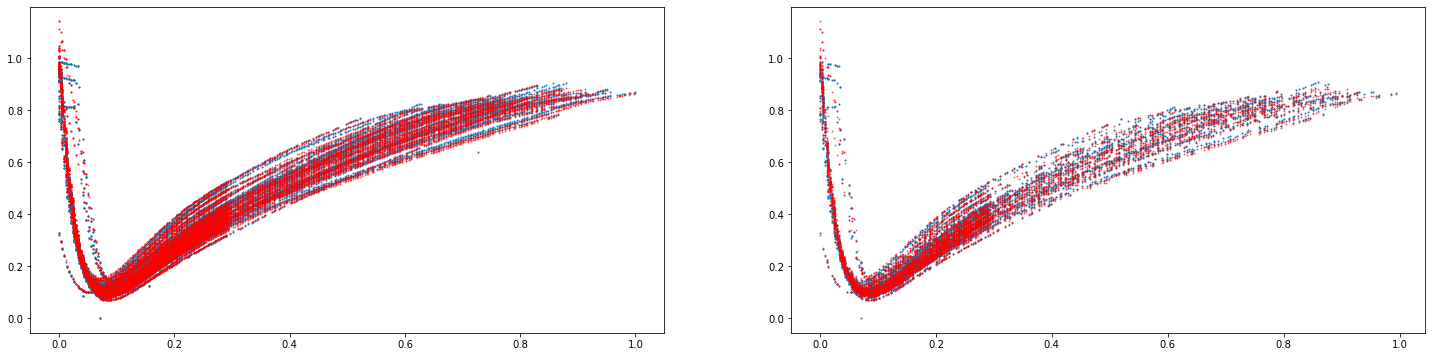

In [25]:
train_losses = []
test_losses  = []
for epoch in range(args['num_epochs']):
    train_losses.append(train(train_loader, net, epoch, False))
    test_losses.append(test(test_loader, net, epoch, False))
    #print('-------------------------------------')
    if epoch%(args['num_epochs']/10) == 0:
      print('Época: %d, Treino: %.4f, Teste: %.4f' % (epoch, train_losses[epoch], test_losses[epoch]))
      #Plotar saida
      # Preparando o Lote para RNA
      saida_rna_treino=[]
      saida_rna_teste=[]
      #amostra_set = Dataset_amostras(dataset_util_norm[teste_idx])
      
      amostra_set = Dataset_amostras(df_train)   
      for i in range(df_train.shape[0]):
        dados,saida = amostra_set[i]
        dados = dados.to(args['device'])
        pred = net(dados).cpu().data.numpy()
        saida_rna_treino.append(pred[0])
      
      amostra_set = Dataset_amostras(df_test)   
      for i in range(df_test.shape[0]):
        dados,saida = amostra_set[i]
        dados = dados.to(args['device'])
        pred = net(dados).cpu().data.numpy()
        saida_rna_teste.append(pred[0])
        
      # Plotando os gráficos
      #plt.rc('figure', figsize=(10,4))
      plt.figure(figsize=(25,6))
      plt.subplot(1, 2, 1)
      #plt.scatter(dataset_util_norm['timex'],dataset_util_norm['temp2'], s=1 )
      plt.scatter(df_train['timex'],df_train['temp2'], s=1 )  
      plt.scatter(df_train['timex'],saida_rna_treino, c='r', s=1, alpha=0.5 )
    
      plt.subplot(1, 2, 2)
      #plt.scatter(dataset_util_norm['timex'],dataset_util_norm['temp2'], s=1 )
      plt.scatter(df_test['timex'],df_test['temp2'], s=1 )  
      plt.scatter(df_test['timex'],saida_rna_teste, c='r', s=1, alpha=0.5 )
      plt.show()

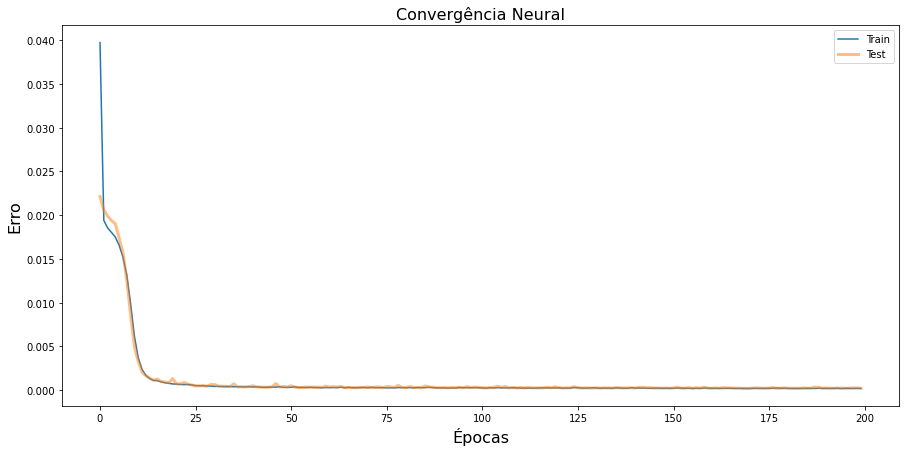

In [26]:
plt.rc('figure', figsize=(15,7))
plt.figure()
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Épocas', fontsize=16)
plt.ylabel('Erro', fontsize=16)
plt.title('Convergência Neural', fontsize=16)
plt.legend()
plt.show()

In [27]:
# Preparando o Lote para RNA
saida_rna=[]
amostra_set = Dataset_amostras(dataset_util_norm[teste_idx])
for i in range(dataset_util[teste_idx].shape[0]):
  dados,saida = amostra_set[i]
  dados = dados.to(args['device'])
  pred = net(dados).cpu().data.numpy()
  saida_rna.append(pred[0])

print(len(saida_rna))


558


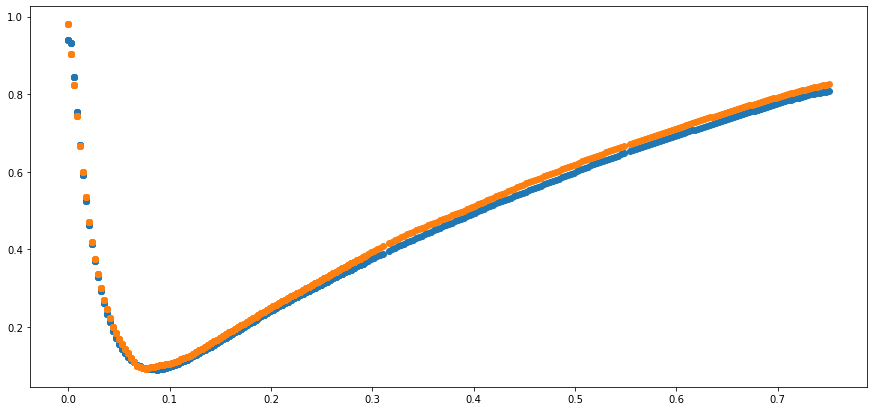

In [28]:
# Plotando os gráficos
plt.rc('figure', figsize=(15,7))
plt.figure()
plt.scatter(dataset_util_norm[teste_idx]['timex'],dataset_util_norm[teste_idx]['temp2'] )
plt.scatter(dataset_util_norm[teste_idx]['timex'],saida_rna )


In [29]:
# Vendo os pesos e bias ajustados
print(net)
#for nome, tensor in net.named_parameters():
#    print(nome, tensor)
torch.save(net, '../datasets/net.pt')

MLP(
  (features): Sequential(
    (0): Linear(in_features=11, out_features=138, bias=True)
    (1): ReLU()
    (2): Linear(in_features=138, out_features=46, bias=True)
    (3): ReLU()
  )
  (out): Linear(in_features=46, out_features=1, bias=True)
)


### Análise dos resultados

População: 6732
Média: 0.6176 Desvio Padrão: 2.1628
Mediana: 0.6506
Intervalo mais frequente: 0.1511 : 0.8779 | Frequência: 2041


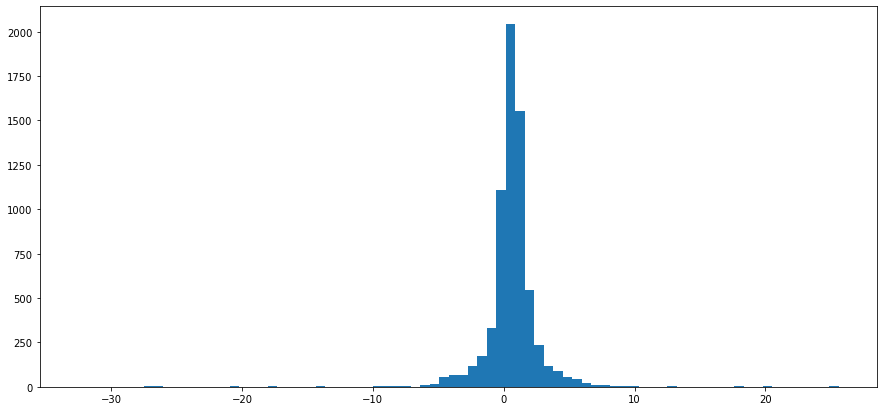

In [30]:
saida_rna_teste = []
erro_rna_teste = []
lista_rna_teste = dataset_util.iloc[indices[train_size:]]['temp2'].to_list()
amostra_set = Dataset_amostras(df_test) 
for i in range(df_test.shape[0]):
    dados,saida = amostra_set[i]
    dados = dados.to(args['device'])
    pred = net(dados).cpu().data.numpy()
    saida_rna_teste.append(pred[0])
    #Desnormalizando os dados
    saida_rna_teste[i] = (saida_rna_teste[i] * (dataset_util['temp2'].max() \
                                                - dataset_util['temp2'].min()) \
                          + dataset_util['temp2'].min())
    #Calculando o erro da amostra
    erro_rna_teste.append((saida_rna_teste[i] - lista_rna_teste[i]))
p=plt.hist(erro_rna_teste, bins=80)
#Encontrando a maior repetição do histograma
print('População: %d' % df_test.shape[0])
print('Média: %.4f Desvio Padrão: %.4f' %(np.mean(erro_rna_teste), np.std(erro_rna_teste)))
print('Mediana: %.4f' %(np.median(erro_rna_teste)))
print('Intervalo mais frequente: %.4f : %.4f | Frequência: %d' %(p[1][np.argmax(p[0])], \
                                                                 p[1][np.argmax(p[0])+1],\
                                                                 np.max(p[0])))

In [31]:
# Qual a probabilidade do resultado estar variando em 5ºC para cima ou para baixo:
from scipy.stats import norm
intervalo = (-1, 1)
erro_media       = np.mean(erro_rna_teste)
erro_desv_padrao = np.std(erro_rna_teste)
Z_superior = (intervalo[1] - erro_media) / erro_desv_padrao
Z_inferior = (intervalo[0] - erro_media) / erro_desv_padrao
prob = norm.cdf(Z_superior) - (1- norm.cdf(Z_superior))
print('A probabilidade que o valor de temperatura tenha uma variação de %.2f até %.2f é de %.2f%%' %(intervalo[0],\
                                                                intervalo[1], prob*100))

A probabilidade que o valor de temperatura tenha uma variação de -1.00 até 1.00 é de 14.03%


In [32]:
nivel_conf = 0.99
erro_max = 1
prob = (nivel_conf/2)+0.5
z = norm.ppf(prob)
N = df_test.shape[0]
s = np.std(erro_rna_teste)
n = ((z**2) * (s**2) * (N)) / (((z**2) * (s**2)) + ((erro_max**2) * (N-1)))
#n = (z * (s / erro_max)) ** 2
n = round(n)
print('Tamanho da Amostra: %d' %n)

Tamanho da Amostra: 31


Média: 0.6131 Desvio Padrão: 0.3851


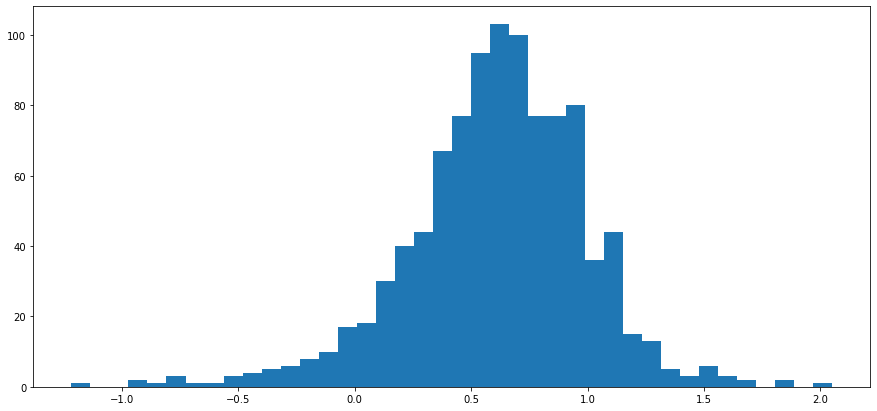

In [33]:
from numpy import random
tam_amostra = n
qtd_amostras = 1000
medias = []
for qtd in range(qtd_amostras):
    medias.append(random.choice(erro_rna_teste, size=tam_amostra).mean())
p=plt.hist(medias, bins=40, density=False)
print('Média: %.4f Desvio Padrão: %.4f' %(np.mean(medias), np.std(medias)))

In [34]:
# Qual o nível de confiança na média
intervalo = norm.interval(alpha = nivel_conf, loc = np.mean(erro_rna_teste), \
                          scale = np.std(erro_rna_teste) / np.sqrt(tam_amostra))
print('O Intervalo de confiança na média é de %.2f%% para um intervalo entre: %.4f e %.4f' \
                          %(nivel_conf*100, intervalo[0], intervalo[1]))

O Intervalo de confiança na média é de 99.00% para um intervalo entre: -0.3830 e 1.6182
